# Import Packages

In [196]:
import os

########################################## basic packages

import pandas as pd
import numpy as np

########################################## plotting packages

# matplotlib
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 20, 6

# Bokeh
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Spectral6, Spectral10


########################################## utility

# To print multiple output in a single cell.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

########################################## Dimension Reduction
import umap


########################################## Modeling

# Train Test Split
from sklearn.model_selection import train_test_split

# Scaler
from sklearn.preprocessing import MinMaxScaler

# Sklearn
from sklearn import svm
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
#from tsfresh.feature_extraction import feature_calculators as fc

In [261]:
final_data = pd.read_csv('final_data.csv')

# Data Manipulation

In [262]:
training_data = final_data[final_data['Season'] < 2019]

training_data = training_data.drop(['Score', 'Opp_Score', 'DayNum', 'NumOT'], axis = 1)
training_data['upset'] = 0
training_data['upset'] = np.where((training_data['Seed_diff'] >= 5) & (training_data['Result']) == 0, 0.5, training_data['upset'])   # only count as upset if a team wins against opponent who is more than 3 upper seed.
training_data['upset'] = np.where((training_data['Seed_diff'] < 5) & (training_data['Result']) == 1, 1, training_data['upset'])   # Regular Wins.
training_data['upset'] = np.where(training_data['Result'] == 0, 0.5, training_data['upset']) # Defeats

training_data.dropna(inplace=True)

# Rename 'Result' to 'Pred'
#training_data = training_data.rename(columns = {'Result':'Pred'})
#training_data.drop(['Loc_N', 'CRType_NCAA'], inplace=True, axis=1)


training_data

,Season,TeamID,Opp_TeamID,Result,Seed_Number,Opp_Seed_Number,Seed_diff,Loc_N,CRType_NCAA,Seed_Group_W,...,AA_Opp_OR_diff,AA_Opp_DR_diff,AA_Opp_Ast_diff,AA_Opp_TO_diff,AA_Opp_Stl_diff,AA_Opp_Blk_diff,AA_Opp_PF_diff,IntraSeason_Opp_Team_Winrate,IntraSeason_Team_Winrate,upset
1136,2003,1421,1411,1,16,16,0,1,1,0,...,10.726496,12.811966,12.440171,4.726496,6.358974,5.128205,5.636752,0.5,0.5,1.0
1137,2003,1112,1436,1,1,16,-15,1,1,0,...,0.048421,-7.288421,-2.943158,-0.962105,-4.162105,-2.898947,-2.648421,0.5,0.5,1.0
1138,2003,1113,1272,1,10,7,3,1,1,0,...,2.157005,3.371981,5.884058,6.000000,0.492754,2.333333,11.702899,0.5,0.5,1.0
1139,2003,1141,1166,1,11,6,5,1,1,0,...,2.848576,-0.484258,0.800600,0.847076,3.445277,0.199400,5.278861,0.5,0.5,0.0
1140,2003,1143,1301,1,8,9,-1,1,1,1,...,-2.126984,-3.960317,1.198413,-3.769841,-4.198413,-1.246032,-5.841270,0.5,0.5,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4363,2018,1181,1242,0,2,1,1,1,1,0,...,-0.192308,-2.528490,2.267806,-1.101140,0.310541,-1.058405,1.971510,0.5,0.5,0.5
4364,2018,1403,1437,0,3,1,2,1,1,1,...,2.666667,3.933333,-1.616667,6.008333,3.000000,1.966667,9.175000,0.5,0.5,0.5
4365,2018,1260,1276,0,11,3,8,1,1,0,...,0.592593,-5.296296,0.592593,-0.555556,2.481481,-0.481481,-2.296296,0.5,0.5,0.5
4366,2018,1242,1437,0,1,1,0,1,1,0,...,4.166667,3.025926,0.096296,1.503704,1.907407,1.448148,1.725926,0.5,0.5,0.5


In [263]:
# Change it to dummies now because TeamID and OppTeamId as integers were needed up untill here.


dummy_cols = ['Season', 'TeamID', 'Opp_TeamID']
non_dummy_cols = list(set(training_data.columns) - set(dummy_cols))

training_data = pd.concat([pd.get_dummies(training_data, columns=dummy_cols), training_data[non_dummy_cols]], axis=1)
training_data = training_data.loc[:,~training_data.columns.duplicated()]
training_data

,Result,Seed_Number,Opp_Seed_Number,Seed_diff,Loc_N,CRType_NCAA,Seed_Group_W,Seed_Group_X,Seed_Group_Y,Seed_Group_Z,...,Opp_TeamID_1453,Opp_TeamID_1454,Opp_TeamID_1455,Opp_TeamID_1457,Opp_TeamID_1458,Opp_TeamID_1459,Opp_TeamID_1460,Opp_TeamID_1461,Opp_TeamID_1462,Opp_TeamID_1463
1136,1,16,16,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1137,1,1,16,-15,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1138,1,10,7,3,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1139,1,11,6,5,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1140,1,8,9,-1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4363,0,2,1,1,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4364,0,3,1,2,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4365,0,11,3,8,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4366,0,1,1,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


# UMAP

In [264]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression


########## upset vs no upset among entire teams
features = training_data.drop(['upset','Result'], axis = 1)
labels = training_data['upset']


scaler = MinMaxScaler()
scaler.fit(features)
features_scaled = scaler.transform(features)


fs = SelectKBest(score_func=f_regression, k=9)


# apply feature selection
fs.fit(features_scaled, labels)

# Get columns to keep and create new dataframe with those only
cols = fs.get_support(indices=True)
features = features.iloc[:,cols]


features

MinMaxScaler(copy=True, feature_range=(0, 1))

F:\Programming\Anaconda\envs\kaggle\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
F:\Programming\Anaconda\envs\kaggle\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
F:\Programming\Anaconda\envs\kaggle\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
F:\Programming\Anaconda\envs\kaggle\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


SelectKBest(k=9, score_func=<function f_regression at 0x00000137B49BD488>)

,Seed_Number,Opp_Seed_Number,Seed_diff,WT_Score_diff,WT_FGM_diff,WT_FGA_diff,WT_DR_diff,WT_Ast_diff,WT_Opp_FGA_diff
1136,16,16,0,-358.0,-107.0,-218.0,-153.0,-61.0,-355.0
1137,1,16,-15,791.0,269.0,572.0,189.0,157.0,582.0
1138,10,7,3,-268.0,-90.0,-360.0,-159.0,-100.0,-319.0
1139,11,6,5,-423.0,-204.0,-455.0,-138.0,-125.0,-237.0
1140,8,9,-1,196.0,117.0,251.0,121.0,50.0,279.0
...,...,...,...,...,...,...,...,...,...
4363,2,1,1,15.0,-9.0,18.0,41.0,15.0,-17.0
4364,3,1,2,-746.0,-282.0,-486.0,-174.0,-153.0,-512.0
4365,11,3,8,-33.0,-3.0,-158.0,4.0,31.0,20.0
4366,1,1,0,-377.0,-104.0,-209.0,-67.0,-45.0,-126.0


In [252]:
scaler = MinMaxScaler()
scaler.fit(features)
features = scaler.transform(features)



reducer = umap.UMAP()
embedding = reducer.fit_transform(features)
embedding.shape
embedding

MinMaxScaler(copy=True, feature_range=(0, 1))

(2082, 2)

array([[  0.46488208,   9.677934  ],
       [-10.783988  ,  -0.77003473],
       [  1.2808986 ,   2.885901  ],
       ...,
       [  4.5245566 ,  -0.2987111 ],
       [  0.75965935,  -5.831656  ],
       [  1.635749  ,  -5.699003  ]], dtype=float32)

In [253]:
new_label = []
new_names = []
for i in labels:
    if i == 0:
        new_names.append('not upset')
    elif i == 1:
        new_names.append('upset')

new_label = np.asarray(new_label)

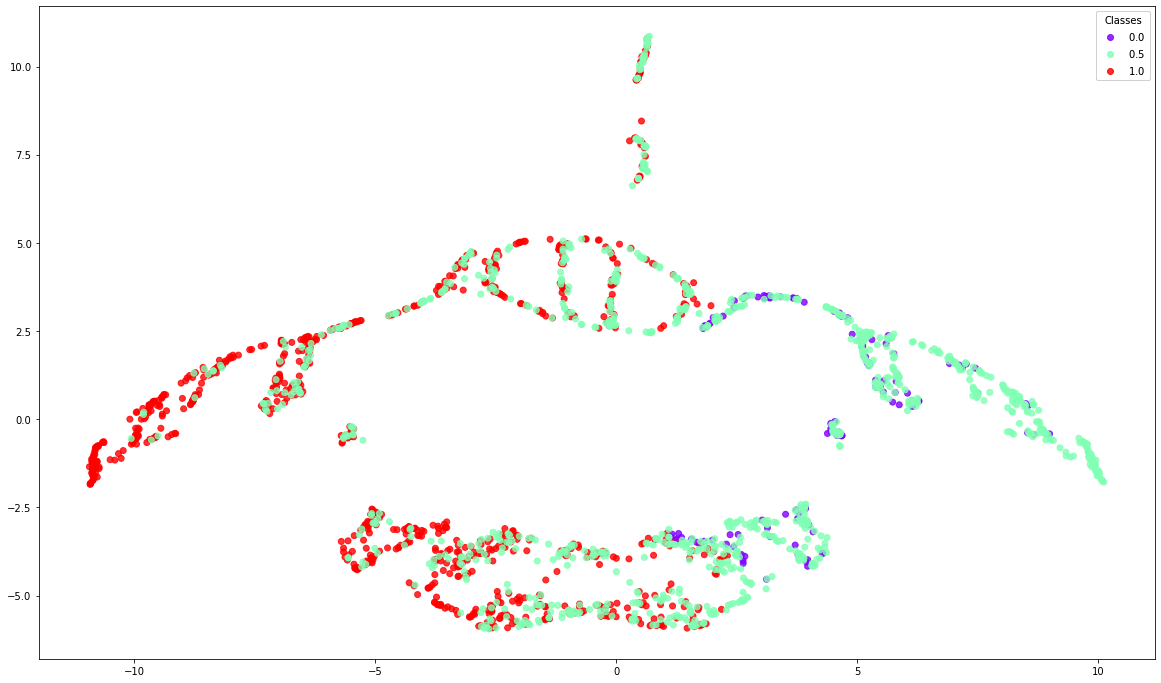

In [254]:
import matplotlib.cm as cm

rcParams['figure.figsize'] = 20, 12

N = 45
x, y = embedding[:, 0], embedding[:, 1]
c = labels


#s = np.random.randint(10, 220, size=N)

fig, ax = plt.subplots()

scatter = ax.scatter(x, y, c=c, alpha=0.8, cmap='rainbow')

legend1 = ax.legend(*scatter.legend_elements(), loc="best", title="Classes")
#legend1.get_texts()[0].set_text('Regular Wins')
#legend1.get_texts()[1].set_text('upsets')
#legend1.get_texts()[2].set_text('Defeat')



ax.add_artist(legend1)


plt.show()


# Model

In [255]:
def umap_func(j):
    ########## upset vs no upset among entire teams
    labels = training_data['upset']
    features = training_data.drop(['Result', 'upset'], axis = 1)
    
    scaler = MinMaxScaler()
    scaler.fit(features)
    features_scaled = scaler.transform(features)
    
    fs = SelectKBest(score_func=f_regression, k=j)


    # apply feature selection     
    fs.fit(features_scaled, labels)

    # Get columns to keep and create new dataframe with those only
    cols = fs.get_support(indices=True)
    features = features.iloc[:,cols]

    scaler = MinMaxScaler()
    scaler.fit(features)
    features = scaler.transform(features)
    
     
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(features)
    
    new_label = []
    new_names = []
    
    
    import matplotlib.cm as cm

    rcParams['figure.figsize'] = 20, 12

    N = 45
    x, y = embedding[:, 0], embedding[:, 1]
    c = labels


    #s = np.random.randint(10, 220, size=N)

    fig, ax = plt.subplots()

    scatter = ax.scatter(x, y, c=c, alpha=0.8, cmap='rainbow')

    legend1 = ax.legend(*scatter.legend_elements(), loc="best", title="Classes")
    legend1.get_texts()[2].set_text('Regular Wins')
    legend1.get_texts()[0].set_text('upsets')
    legend1.get_texts()[1].set_text('Defeat')
    
    ax.add_artist(legend1)


    plt.savefig(f'F:\\OneDrive - Georgia State University\\Data Science\\Competition\\Kaggle_Competion\\Google Cloud & NCAA® ML Competition 2020-NCAAM\\2019 Season Simulation\\Umap after dummies\\{j} variables.png')
    plt.close(fig)  
    
    
    print(j)   

    

    

In [256]:
for j in range(1, 10):
    x = umap_func(j)
    x

F:\Programming\Anaconda\envs\kaggle\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
F:\Programming\Anaconda\envs\kaggle\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
F:\Programming\Anaconda\envs\kaggle\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
F:\Programming\Anaconda\envs\kaggle\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
F:\Programming\Anaconda\envs\kaggle\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 21 separate connected components using meta-embedding (experimental)
  n_components


1


F:\Programming\Anaconda\envs\kaggle\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
F:\Programming\Anaconda\envs\kaggle\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
F:\Programming\Anaconda\envs\kaggle\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
F:\Programming\Anaconda\envs\kaggle\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
F:\Programming\Anaconda\envs\kaggle\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 24 separate connected components using meta-embedding (experimental)
  n_components


2


F:\Programming\Anaconda\envs\kaggle\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
F:\Programming\Anaconda\envs\kaggle\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
F:\Programming\Anaconda\envs\kaggle\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
F:\Programming\Anaconda\envs\kaggle\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
F:\Programming\Anaconda\envs\kaggle\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 24 separate connected components using meta-embedding (experimental)
  n_components


3


F:\Programming\Anaconda\envs\kaggle\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
F:\Programming\Anaconda\envs\kaggle\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
F:\Programming\Anaconda\envs\kaggle\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
F:\Programming\Anaconda\envs\kaggle\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


4


F:\Programming\Anaconda\envs\kaggle\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
F:\Programming\Anaconda\envs\kaggle\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
F:\Programming\Anaconda\envs\kaggle\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
F:\Programming\Anaconda\envs\kaggle\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


5


F:\Programming\Anaconda\envs\kaggle\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
F:\Programming\Anaconda\envs\kaggle\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
F:\Programming\Anaconda\envs\kaggle\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
F:\Programming\Anaconda\envs\kaggle\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


6


F:\Programming\Anaconda\envs\kaggle\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
F:\Programming\Anaconda\envs\kaggle\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
F:\Programming\Anaconda\envs\kaggle\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
F:\Programming\Anaconda\envs\kaggle\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


7


F:\Programming\Anaconda\envs\kaggle\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
F:\Programming\Anaconda\envs\kaggle\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
F:\Programming\Anaconda\envs\kaggle\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
F:\Programming\Anaconda\envs\kaggle\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


8


F:\Programming\Anaconda\envs\kaggle\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
F:\Programming\Anaconda\envs\kaggle\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
F:\Programming\Anaconda\envs\kaggle\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
F:\Programming\Anaconda\envs\kaggle\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


9


## 3 classification [win, upset, lose]

In [265]:
training_data

,Result,Seed_Number,Opp_Seed_Number,Seed_diff,Loc_N,CRType_NCAA,Seed_Group_W,Seed_Group_X,Seed_Group_Y,Seed_Group_Z,...,Opp_TeamID_1453,Opp_TeamID_1454,Opp_TeamID_1455,Opp_TeamID_1457,Opp_TeamID_1458,Opp_TeamID_1459,Opp_TeamID_1460,Opp_TeamID_1461,Opp_TeamID_1462,Opp_TeamID_1463
1136,1,16,16,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1137,1,1,16,-15,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1138,1,10,7,3,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1139,1,11,6,5,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1140,1,8,9,-1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4363,0,2,1,1,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4364,0,3,1,2,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4365,0,11,3,8,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4366,0,1,1,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [266]:
features = training_data.drop(['Result', 'upset'], axis = 1)
labels = training_data['upset']

scaler = MinMaxScaler()
scaler.fit(features)
features_scaled = scaler.transform(features)

#submission_features = test_data.drop('Pred', axis=1)

#scaler = MinMaxScaler()
#scaler.fit(submission_features)
#submission_features_scaled = scaler.transform(submission_features)

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features_scaled, labels, test_size = 0.25, random_state = 42)

scaler = MinMaxScaler()
scaler.fit(train_features)
train_features_scaled = scaler.transform(train_features)

scaler = MinMaxScaler()
scaler.fit(test_features)
test_features_scaled = scaler.transform(test_features)

print('Training Features Shape:', train_features_scaled.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features_scaled.shape)
print('Testing Labels Shape:', test_labels.shape)

#print('Submission Features Shape:', submission_features_scaled.shape)


# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
#features = np.array(features)

MinMaxScaler(copy=True, feature_range=(0, 1))

MinMaxScaler(copy=True, feature_range=(0, 1))

MinMaxScaler(copy=True, feature_range=(0, 1))

Training Features Shape: (1561, 1043)
Training Labels Shape: (1561,)
Testing Features Shape: (521, 1043)
Testing Labels Shape: (521,)


In [267]:
scaler = MinMaxScaler()
scaler.fit(features)
features_scaled = scaler.transform(features)


fs = SelectKBest(score_func=f_regression, k=10)


# apply feature selection     
fs.fit(features_scaled, labels)

# Get columns to keep and create new dataframe with those only
cols = fs.get_support(indices=True)
features = features.iloc[:,cols]

MinMaxScaler(copy=True, feature_range=(0, 1))

F:\Programming\Anaconda\envs\kaggle\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
F:\Programming\Anaconda\envs\kaggle\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
F:\Programming\Anaconda\envs\kaggle\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
F:\Programming\Anaconda\envs\kaggle\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


SelectKBest(k=10, score_func=<function f_regression at 0x00000137B49BD488>)

In [271]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features_scaled, train_labels);

In [289]:
# Use the forest's predict method on the test data
predictions_rf = rf.predict(test_features_scaled)

# Calculate the log loss
#logloss = log_loss(test_labels, predictions_rf)
# Print out the mean absolute error (mae)
#print('log_loss Error:', logloss)

In [312]:
import numpy as np
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate(comparison):
    new_df = comparison
    mse = mean_squared_error(new_df['actual'], new_df['prediction'])
    mape = mean_absolute_percentage_error(new_df['actual'], new_df['prediction'])
    mae = mean_absolute_error(new_df['actual'], new_df['prediction'])
    #mean_error = 
    
    return new_df, mse, mae, mape

    print(f'\nRMSE: {math.sqrt(mse)}\nMAE: {mae}, \nMAPE: {mape}')  

comparison = pd.DataFrame(data=np.column_stack((test_labels, predictions_rf)),columns=['actual','prediction'])



#comparison1 = pd.concat([, pd.Series()], axis=1)
new_df, mse, mae, mape = evaluate(comparison)

print(f'\nRMSE: {math.sqrt(mse)}\nMAE: {mae}\n MAPE: {mape}')   

,actual,prediction
0,0.5,0.5
1,1.0,1.0
2,0.5,0.5
3,1.0,1.0
4,1.0,1.0
...,...,...
516,0.5,0.5
517,1.0,1.0
518,0.5,1.0
519,0.5,0.5



RMSE: 0.30353009444561685
MAE: 0.18426103646833014
 MAPE: nan


F:\Programming\Anaconda\envs\kaggle\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
F:\Programming\Anaconda\envs\kaggle\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


In [291]:
Error = np.sum(np.abs(np.subtract(comparison['actual'],comparison['prediction'])))
Average = np.sum(comparison['actual'])
MAPE = Error/Average

MAPE

0.3040168302945302

In [ ]:
rf = RandomForestRegressor()
params = {
    'n_estimators' : [10,100,1000],
    'max_depth' : [1,3,5,10,100],
    'min_samples_leaf': [1,50,150,300]
}
gs = GridSearchCV(rf, params)

gs.fit(features_scaled, labels)
gs.best_score_
preds = gs.best_estimator_.predict(submission_features_scaled)

# XGB

In [346]:
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import KFold


In [347]:
print('Training Features Shape:', train_features_scaled.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features_scaled.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (1561, 1043)
Training Labels Shape: (1561,)
Testing Features Shape: (521, 1043)
Testing Labels Shape: (521,)


In [348]:
dtrain = xgb.DMatrix(train_features_scaled, label = train_labels)

In [317]:
def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 5000 
    x =  preds-labels    
    grad = x / (x**2/c**2+1)
    hess = -c**2*(x**2-c**2)/(x**2+c**2)**2
    return grad, hess

In [349]:
param = {} 
#param['objective'] = 'reg:linear'
param['eval_metric'] =  'mae'
param['booster'] = 'gbtree'
param['eta'] = 0.05 #change to ~0.02 for final run
param['subsample'] = 0.35
param['colsample_bytree'] = 0.7
param['num_parallel_tree'] = 3 #recommend 10
param['min_child_weight'] = 40
param['gamma'] = 10
param['max_depth'] =  3
param['silent'] = 1

print(param)
booster = xgb.train(param, dtrain, num_boost_round=100)

{'eval_metric': 'mae', 'booster': 'gbtree', 'eta': 0.05, 'subsample': 0.35, 'colsample_bytree': 0.7, 'num_parallel_tree': 3, 'min_child_weight': 40, 'gamma': 10, 'max_depth': 3, 'silent': 1}


In [351]:
dtest = xgb.DMatrix(test_features_scaled)

result = booster.predict(dtest)
#result = result.astype(int)

comparison = pd.DataFrame(data=np.column_stack((test_labels, result)),columns=['actual','prediction'])



#comparison1 = pd.concat([, pd.Series()], axis=1)
new_df, mse, mae, mape = evaluate(comparison)

print(f'\nRMSE: {math.sqrt(mse)}\nMAE: {mae}\n MAPE: {mape}')   


RMSE: 0.2593202052359894
MAE: 0.22993492919973127
 MAPE: inf


F:\Programming\Anaconda\envs\kaggle\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


In [352]:
xgb_cv = []
repeat_cv = 10 # recommend 10

for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = param,
          dtrain = dtrain,
          obj = cauchyobj,
          num_boost_round = 3000,
          folds = KFold(n_splits = 5, shuffle = True, random_state = i),
          early_stopping_rounds = 25,
          verbose_eval = 50
        )
    )

Fold repeater 0
[0]	train-mae:0.24769+0.00224	test-mae:0.24768+0.01145
Fold repeater 1
[0]	train-mae:0.24734+0.00459	test-mae:0.24742+0.01807
Fold repeater 2
[0]	train-mae:0.24734+0.00208	test-mae:0.24739+0.00886
Fold repeater 3
[0]	train-mae:0.24749+0.00420	test-mae:0.24754+0.01648
Fold repeater 4
[0]	train-mae:0.24759+0.00399	test-mae:0.24759+0.01548
Fold repeater 5
[0]	train-mae:0.24737+0.00308	test-mae:0.24746+0.01265
Fold repeater 6
[0]	train-mae:0.24763+0.00296	test-mae:0.24765+0.00920
Fold repeater 7
[0]	train-mae:0.24757+0.00382	test-mae:0.24759+0.01299
Fold repeater 8
[0]	train-mae:0.24758+0.00392	test-mae:0.24761+0.01337
Fold repeater 9
[0]	train-mae:0.24760+0.00176	test-mae:0.24766+0.00813


In [353]:
iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]
iteration_counts, val_mae

([10, 11, 10, 12, 10, 12, 10, 12, 10, 11],
 [0.23180300000000004,
  0.23063099999999997,
  0.2309974,
  0.2303204,
  0.23151960000000002,
  0.23086859999999998,
  0.23180260000000003,
  0.230499,
  0.231164,
  0.23192440000000003])

In [334]:
oof_preds = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = train_labels.copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    for train_index, val_index in kfold.split(train_features_scaled, train_labels):
        dtrain_i = xgb.DMatrix(train_features_scaled[train_index], label = train_labels[train_index])
        dval_i = xgb.DMatrix(train_features_scaled[val_index], label = train_labels[val_index])  
        model = xgb.train(
              params = param,
              dtrain = dtrain_i,
              num_boost_round = iteration_counts[i],
              verbose_eval = 50
        )
        preds[val_index] = model.predict(dval_i)
    oof_preds.append(np.clip(preds,-30,30))

Fold repeater 0


KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

In [333]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(train_labels>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
        
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    
    print(f"logloss of cvsplit {i}: {log_loss(np.where(train_labelsain_labels>0,1,0),spline_fit)}") 

IndexError: list index out of range

In [ ]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0), "spline":spline_model[0](oof_preds[0])})
plot_df["pred_int"] = (plot_df["pred"]).astype(int)
plot_df = plot_df.groupby('pred_int')['spline','label'].mean().reset_index()

plt.figure()
plt.plot(plot_df.pred_int,plot_df.spline)
plt.plot(plot_df.pred_int,plot_df.label)